# Transfer Learning


## Convolutional Neural Networks

---

In this notebook, we use transfer learning to train a CNN to classify dog breeds.

### 1. Load Dog Dataset

Before running the code cell below, download the dataset of dog images [here](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip) and place it in the respository.

In [ ]:
!pip install opencv-python

In [7]:
from sklearn.datasets import load_files       
from tensorflow.keras.utils import to_categorical 
import numpy as np
from glob import glob

In [8]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load ordered list of dog names
dog_names = [item[25:-1] for item in glob('dogImages/train/*/')]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % str(len(train_files) + len(valid_files) + len(test_files)))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### 2. Visualize the First 12 Training Images

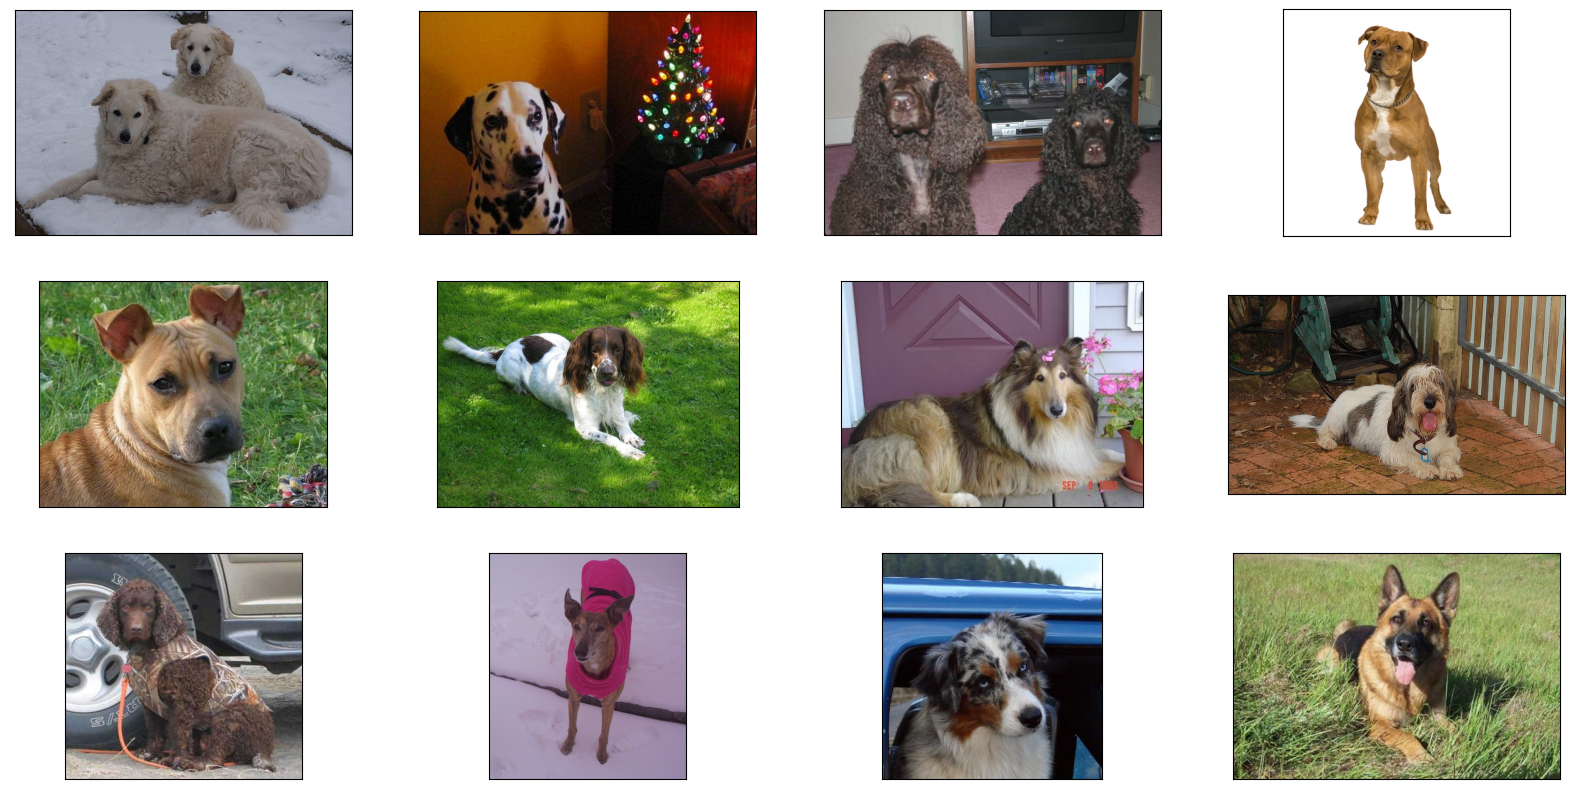

In [9]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_img(img_path, ax):
    img = cv2.imread(img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(20, 10))
for i in range(12):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    visualize_img(train_files[i], ax)

### 3. Obtain the VGG-16 Bottleneck Features

Before running the code cell below, download the file linked [here](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG16Data.npz) and place it in the `bottleneck_features/` folder.

In [ ]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_vgg16 = bottleneck_features['train']
valid_vgg16 = bottleneck_features['valid']
test_vgg16 = bottleneck_features['test']

### 4. Define a Model Architecture (Model 1)

In [ ]:
from keras.layers import Dense, Flatten
from keras.models import Sequential

model = Sequential()
model.add(Flatten(input_shape=(7, 7, 512)))
model.add(Dense(133, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])
model.summary()

### 5. Define another Model Architecture (Model 2)

In [ ]:
from keras.layers import GlobalAveragePooling2D

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=(7, 7, 512)))
model.add(Dense(133, activation='softmax'))
model.summary()

### 6. Compile the Model (Model 2)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

### 7. Train the Model (Model 2)

In [ ]:
from keras.callbacks import ModelCheckpoint   

# train the model
checkpointer = ModelCheckpoint(filepath='dogvgg16.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
model.fit(train_vgg16, train_targets, epochs=20, validation_data=(valid_vgg16, valid_targets), 
          callbacks=[checkpointer], verbose=1, shuffle=True)

### 8. Load the Model with the Best Validation Accuracy (Model 2)

In [ ]:
# load the weights that yielded the best validation accuracy
model.load_weights('dogvgg16.weights.best.hdf5')

### 9. Calculate Classification Accuracy on Test Set (Model 2)

In [ ]:
# get index of predicted dog breed for each image in test set
vgg16_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) 
                     for feature in test_vgg16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(vgg16_predictions)==
                           np.argmax(test_targets, axis=1))/len(vgg16_predictions)
print('\nTest accuracy: %.4f%%' % test_accuracy)